In [88]:
from fenics import *
import matplotlib.pyplot as plt

## Pre-stress for initial conditions

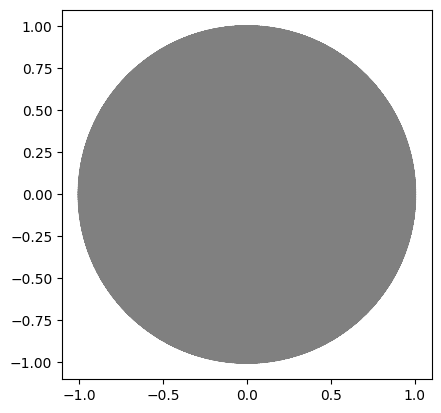

In [89]:
filename = "mesh/meshCircle"
mesh = Mesh(filename + ".xml")
bounds = MeshFunction("size_t", mesh, filename + "_facet_region.xml")
face = MeshFunction("size_t", mesh, filename + "_physical_region.xml")
plot(mesh)

In [90]:
# Scaled variables
E = 1e3
nu = 0.3
mu = E / (2 * (1 + nu))
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))

# Create mesh and define function space
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
tol = 1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol
g = Expression(("2*x[0]/sqrt(x[0]*x[0]+x[1]*x[1])", "2*x[1]/sqrt(x[0]*x[0]+x[1]*x[1])"), degree=2)
bc = DirichletBC(V, g, bounds,1)

# Define strain and stress

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension() # space dimension
v = TestFunction(V)
f = Constant((0, 0))  # body force
T = Constant((0, 0))
q = 1e4
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds

# Compute solution
u0 = Function(V)
solve(a == L, u0, bc)


Solving linear variational problem.


## Visco-elastic model

In [91]:
# parameters and util functions

E = 1e5
nu = 6*1e7
q = 3.09*1e5

def sym_grad(u):
    return 0.5*(grad(u) + grad(u).T)

def antisym_grad(u):
    return 0.5*(grad(u) - grad(u).T)

def sigma(u):
    return 2*nu*sym_grad(u) #+ 2*E*eps


In [92]:
def f_eps(eps,u):
    Wu = project(antisym_grad(u),W)
    Du = project(sym_grad(u),W)
    return Du - dot(v, grad(eps)) - eps * Wu + Wu * eps - (Du*eps + eps*Wu)

def RK4(eps_n, u, dt):
    k1 = dt*f_eps(eps_n, u)
    k2 = dt*f_eps(eps_n + 0.5*k1, u)
    k3 = dt*f_eps(eps_n + 0.5*k2, u)
    k4 = dt*f_eps(eps_n + k3, u)
    eps_new = eps_n + (k1 + 2*k2 + 2*k3 + k4)/6
    return project(eps_new, W)

In [93]:
# Create mesh

filename = "mesh/meshHoles"
mesh_init = Mesh(filename + ".xml")
bounds = MeshFunction("size_t", mesh_init, filename + "_facet_region.xml")
face = MeshFunction("size_t", mesh_init, filename + "_physical_region.xml")

Solving linear variational problem.


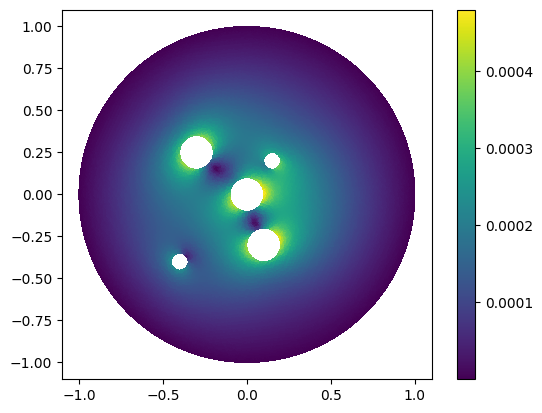

Calling FFC just-in-time (JIT) compiler, this may take some time.
Found different Arguments with same number and part.
Did you combine test or trial functions from different spaces?
The Arguments found are:
  v_0
  v_0


UFLException: Found different Arguments with same number and part.
Did you combine test or trial functions from different spaces?
The Arguments found are:
  v_0
  v_0

In [94]:
# Create function spaces

V = VectorFunctionSpace(mesh_init, 'P', 1)
W = TensorFunctionSpace(mesh_init, 'P', 1)

# Define boundary condition

bc_out = DirichletBC(V, Constant((0,0)), bounds, 1)
g = Expression(("-0.01*(x[0]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))", "-0.01*(x[1]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))"), degree=2)
bc_in = DirichletBC(V, g, bounds, 4)
bcs = [bc_out] #, bc_in]

# Define variational problem
dt = 0.1
eps0 = Function(W)
u0 = interpolate(u0, V)
eps0.assign(project(sym_grad(u0),W))
for t in range(2):
    
    V = VectorFunctionSpace(mesh_init, 'P', 1)
    bc_in = DirichletBC(V, g, bounds, 4)
    bc_out = DirichletBC(V, Constant((0,0)), bounds, 1)
    bcs = [bc_out] #, bc_in]
    utrial = TrialFunction(V)
    v = TestFunction(V)
    u0 = interpolate(u0, V)
    a_sigma = inner(2*nu*sym_grad(utrial), sym_grad(v))*dx + q*inner(utrial,v)*dx
    L_sigma = - inner(2*E*eps0, sym_grad(v))*dx

    u = Function(V)

    solve(a_sigma == L_sigma, u, bcs)
    if t % 5 == 0:
        sol = plot(u,mode='displacement')
        plt.colorbar(sol)
        plt.show()
    # mesh update
    # u0.assign(u)
    ALE.move(mesh_init, u)
    W = TensorFunctionSpace(mesh_init, 'P', 1)
    eps0 = interpolate(eps0, W)
    # eps_new = project(RK4(eps0, u, dt), W)
    eps0.assign(RK4(eps0, u, dt))
    
    print(eps.vector().get_local())
    # eps0.assign(eps)

